In [1]:
library(sf)
library(ggplot2)
library(tidyverse)
library(tibble)
library(magrittr)
library(redist)
library(sp)
library(spData)
library(spdep)
library(igraph)

ff_2015_file <- "C:/Users/madie/OneDrive/data/pre-redist/VA_precinct_2015_fairfax/VA_precinct_2015_fairfax.shp"
df <- st_read(ff_2015_file)

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:purrr':

    compose, simplify


The following object is masked from 'package:tidyr':

    crossing


The following object is masked from 'package:tibble':

    a

Reading layer `VA_precinct_2015_fairfax' from data source `C:\Users\madie\OneDrive\data\pre-redist\VA_precinct_2015_fairfax\VA_precinct_2015_fairfax.shp' using driver `ESRI Shapefile'
Simple feature collection with 253 features and 14 fields
geometry type:  POLYGON
dimension:      XYZ
bbox:           xmin: 11757190 ymin: 6905741 xmax: 11899000 ymax: 7070364
z_range:        zmin: 0 zmax: 0
projected CRS:  NAD83 / Virginia North (ftUS)


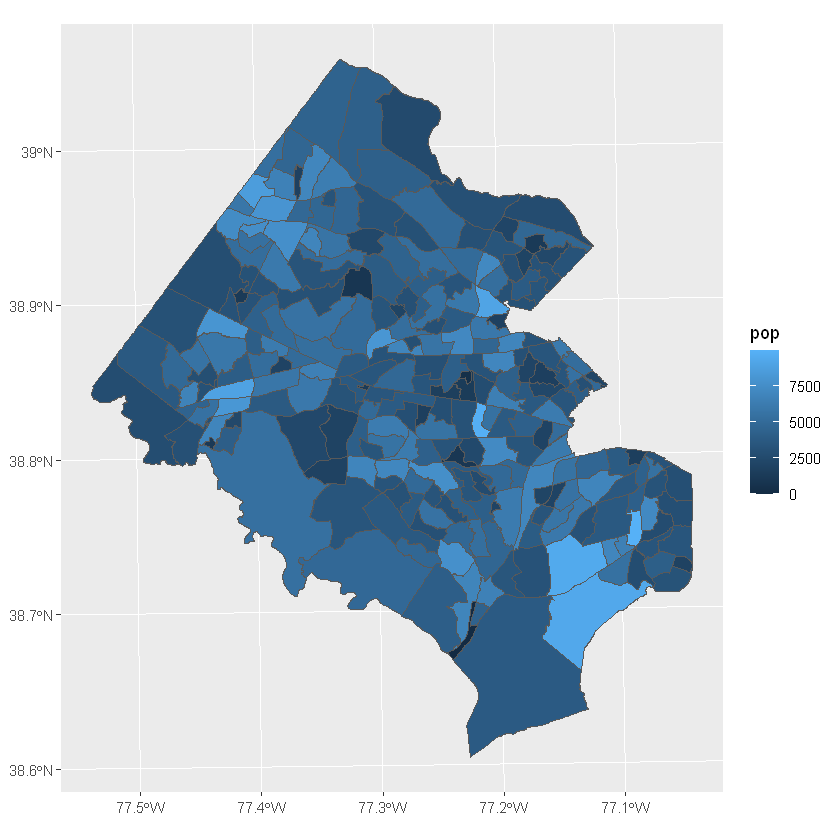

In [7]:
df %>% ggplot(aes(fill = pop)) + 
  geom_sf()

In [2]:
# generate adjacency list
adjlist <- redist.adjacency(df)

In [3]:
# generate 10 random colors that are distinct so that the different districts are distinguishable. 
library(randomcoloR)
colors <- distinctColorPalette(k=10)

In [4]:
# trying to figure out how to calculate that dang distancemat
centroid <- st_centroid(df$geometry)
distancemat <- st_distance(centroid, centroid)

In [5]:
## ----------------------------------------------------------
## Constrain on population and compactness with tempering,
## weight on population = 5.4 while weight on compactness = 3
## Also specifying argument for ssdmat, the distance matrix
## ----------------------------------------------------------
betaweights <- rep(NA, 10); for(i in 1:10){betaweights[i] <- 2^i}
mcmc.out.st.multiple <- redist.mcmc(adjobj = adjlist,
                                    popvec = df$pop,
                                    ndists = 10,
                                    nsims = 10000,
                                    constraint = c("population", "compact"),
                                    constraintweights = c(1, 2),
                                    ssdmat = distancemat,
                                    temper = TRUE)



redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.


Using redist.rsg() to generate starting values.

10 percent done.
Metropolis acceptance ratio: 0.961962

20 percent done.
Metropolis acceptance ratio: 0.962981

30 percent done.
Metropolis acceptance ratio: 0.96132

40 percent done.
Metropolis acceptance ratio: 0.95999

50 percent done.
Metropolis acceptance ratio: 0.960992

60 percent done.
Metropolis acceptance ratio: 0.96066

70 percent done.
Metropolis acceptance ratio: 0.96028

80 percent done.
Metropolis acceptance ratio: 0.959745

90 percent done.
Metropolis acceptance ratio: 0.960996

100 percent done.
Metropolis acceptance ratio: 0.959296



In [8]:
mcmc.out.st <- redist.ipw(mcmc.out.st.multiple)

ERROR: Error in sample.int(length(x), size, replace, prob): too few positive probabilities


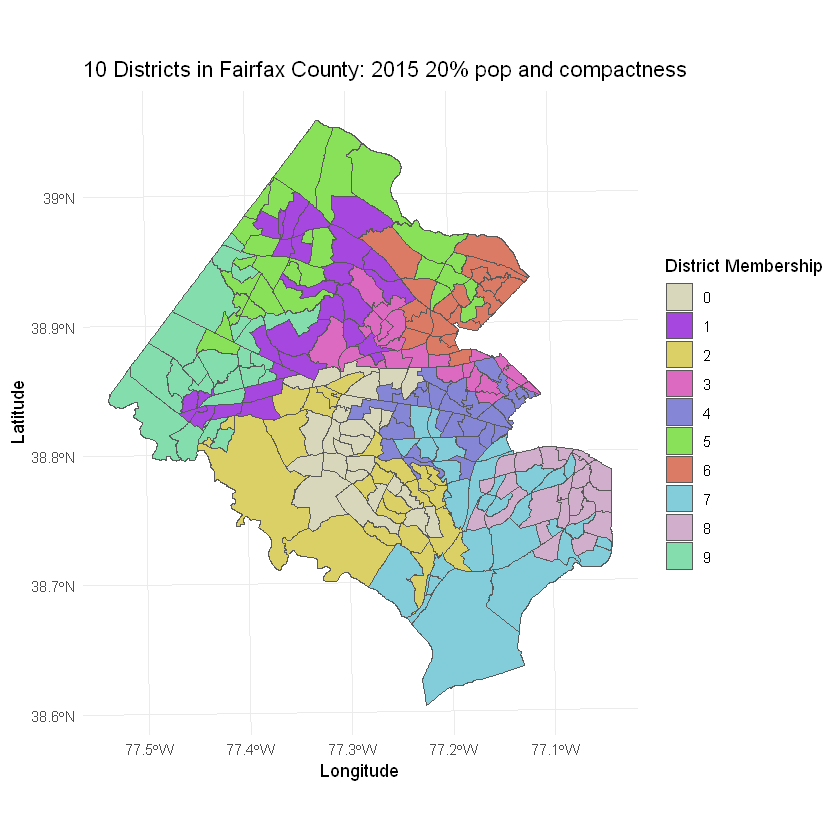

In [13]:
cds <- mcmc.out.st.multiple$partitions[,253]
plot_4 <- redist.map(shp=df, 
        district_membership=cds, 
        centroids=FALSE, 
        edges=FALSE,
        title="10 Districts in Fairfax County: 2015 20% pop and compactness") +
        theme(legend.position="right") +
        scale_fill_manual(values = colors)
        # geom_sf_label(aes(label = cds))
#ggsave("fairfax_10.png")
plot_4

In [11]:
length(mcmc.out.st.multiple$partitions[,1])

[1] 253

In [14]:
RNGkind(kind = "L'Ecuyer-CMRG")
set.seed(1)
nchains <- 4
nsims <- 10000


In [15]:
mcmc_chains <- lapply(1:nchains, function(x){
          redist.mcmc(adjobj = adjlist, 
                      popvec = df$pop, 
                      nsims = nsims,
                      ndists = 10)
})


redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.


Using redist.rsg() to generate starting values.

10 percent done.
Metropolis acceptance ratio: 0.943944

20 percent done.
Metropolis acceptance ratio: 0.953477

30 percent done.
Metropolis acceptance ratio: 0.956986

40 percent done.
Metropolis acceptance ratio: 0.95849

50 percent done.
Metropolis acceptance ratio: 0.956191

60 percent done.
Metropolis acceptance ratio: 0.956159

70 percent done.
Metropolis acceptance ratio: 0.957137

80 percent done.
Metropolis acceptance ratio: 0.958245

90 percent done.
Metropolis acceptance ratio: 0.957217

100 percent done.
Metropolis acceptance ratio: 0.957396


redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.


Using redist.rsg() to generate starting values.

10 percent done.
Metropolis acceptance ratio: 0.973974

20 percent done.
Metropolis acceptance ratio: 0.95998

30 

In [17]:
mcmc_chains

Warning message in max(x$cdvec[, 1]):
"no non-missing arguments to max; returning -Inf"
ERROR while rich displaying an object: Error in if (x$pct_dist_parity < 1) cat(" and a ", 100 * x$pct_dist_parity, : argument is of length zero

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL